We will now perform a regression analysis using one of our technical indicators. Regression analysis is a statistical method used to examine the relationship between a dependent variable — the outcome we want to explain and eventually predict — and one or more independent variables that may help to explain its behavior.

To conduct this analysis, we will use the Python library scikit-learn, a powerful toolkit for machine learning and data analysis. It offers tools not only for regression, but also for techniques such as clustering, classification, dimensionality reduction (e.g., PCA, LDA), and other machine learning models that allow us to explore and model financial data more effectively.

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk

C:\Users\Ferna\AppData\Local\Temp\ipykernel_32900\1866341959.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Coefficient: -1.708709244442512e-05
Intercept: 0.001421415492806479
R-squared: 0.0006266368420089208


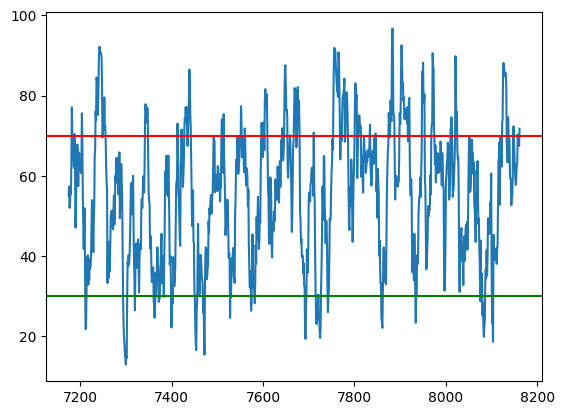

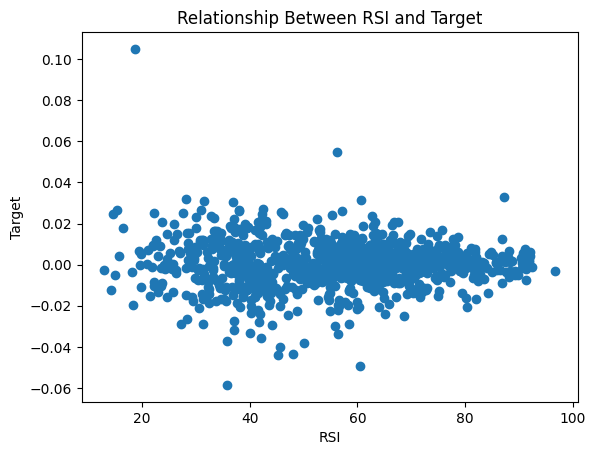

: 

In [ ]:
# General parameters
TICKER = 'SPY'
INTERVAL = '1d'
SHIFT = 1

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# RSI parameters
RSI_LENGTH = 14
OVERBOUGHT = 70 
OVERSOLD = 30

# subsection of data we are interested
LOOKBACK = 1000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

# Define the dependent variable (Y)

def add_target(df, shift = SHIFT):
    df[f'Close + {shift}'] = df['Close'].shift(-shift) 
    
    # This helps us correlate the price change 'shift' periods into the future 
    # with the information available today.
    # For example, if SHIFT = 1, we're linking tomorrow's change with today's data.
    # If SHIFT = 5, we're linking the change in five days with today's data.

    # Difference between Close price SHIFT days from now and Close price now
    df['Target'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    # Alternative: df['Target'] = df['Close'].diff().shift(-shift)
    
    return df


def add_RSI(df, lenght = RSI_LENGTH):

    price_change = df['Close'].diff() #diff() => current value - previous value

    # Separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = - price_change.where(price_change < 0, 0)

    # Average gain vs loss
    avg_gain = gain.rolling(window = lenght).mean()
    avg_loss = loss.rolling(window = lenght).mean()

    # Calculate RSI
    rs = avg_gain/avg_loss # what % of the avg loss is the avg gain
    rsi = 100 - (100/(1 + rs))

    df['RSI'] = rsi

    # plot the RSI
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green') 

    return df.dropna()

# We are trying to explain how the RSI is related to future price movements
def generate_linear_regression(df, features ='RSI', target ='Target'):

    subset = df[[features, target]].dropna()  # Sub-dataframe that contains only the relevant columns and drops missing values

    X = subset[[features]].values  # X must be a 2D array for sklearn (features) → shape (n_samples, 1)
    y = subset[target].values    # Y can be a 1D array (target variable) → shape (n_samples,)

    model = sk.linear_model.LinearRegression()  # Create a Linear Regression model instance

    model.fit(X, y)  # Fit the model using RSI (X) to predict Target (Y)

    y_pred = model.predict(X)  # Generate predictions for Y based on the fitted model

    r2 = sk.metrics.r2_score(y, y_pred)  # Compute R² to measure how well the model explains variability in Y

    # Print model parameters
    print(f'Coefficient: {model.coef_[0]}') # Shows how much Target changes per unit of RSI, 0 is for fisrt coef
    print(f'Intercept: {model.intercept_}') # Value of Target when RSI is 0 
    print(f'R-squared: {r2}') # Goodness of fit: % of variance in Y explained by RSI

    # Plot the relationship between features (X) and Target (Y)
    plt.figure()
    plt.scatter(X, y)
    plt.xlabel(f'{features}')
    plt.ylabel(f'{target}')
    plt.title(f'Relationship Between {features} and {target}')

    return model  


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    df = generate_linear_regression(df)

    return df

df = main()